# Part 2: Supervised Learning & Temporal Robustness Analysis 
## (Second Trial of Part 2)
 Part 1 created the labels. Now, can AI predict these labels correctly?

### 1) Load files and create target labels

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Read cluster results from JSON file
with open('data/result/countries_per_cluster.json', 'r', encoding='utf-8') as f:
    cluster_json = json.load(f)

# Convert JSON to {ClusterID: [Countries]} format
clusters_data = {}
for item in cluster_json:
    c_id = item['cluster_kmeans']
    c_countries = item['countries']
    clusters_data[c_id] = c_countries

# Create a mapping dictionary: Country -> Cluster
country_to_cluster = {}
for cluster_id, countries in clusters_data.items():
    for country in countries:
        country_to_cluster[country] = cluster_id

# Read the main dataset (weekly features)
df_raw = pd.read_csv('data/processed/country_index_matrix_HIGH_VARIANCE.csv')

### 2) DAata Preprocessing

In [7]:
# Add cluster label to each row based on the country
df_raw['Cluster'] = df_raw['Country'].map(country_to_cluster)

# Remove rows that do not have a cluster label if theres any
df_clean = df_raw.dropna(subset=['Cluster'])

# Split features X and target y
# We remove 'date', 'Country' and 'Cluster' from feature set
X = df_clean.drop(columns=['date', 'Country', 'Cluster'])
y = df_clean['Cluster']

# Fill missing values with 0
X = X.fillna(0)

print(f"Dataset total rows: {X.shape[0]}")
print(f"Number of features used: {X.shape[1]}")

Dataset total rows: 11060
Number of features used: 24


### 3)Model Training (with baseline settings)

Logistic Regression : %89.69
Decision Tree       : %94.62
Random Forest       : %99.37
SVM (RBF)           : %97.47


Text(0.5, 1.0, 'Comparison of Baseline Models')

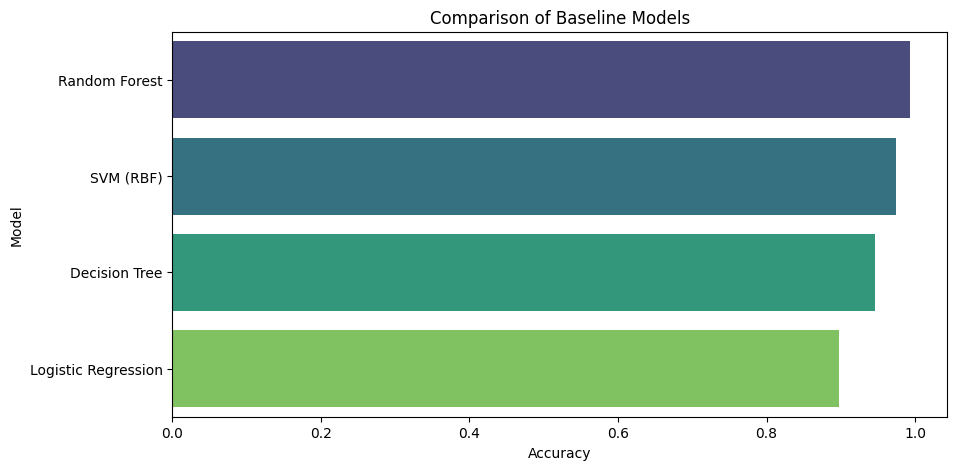

In [8]:
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data  for SVM and Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Define the models with baseline settings
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42), 
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42)
}

results = []
for name, model in baseline_models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"{name:<20}: %{acc*100:.2f}")

df_res = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=df_res, hue='Model', palette='viridis', legend=False)
plt.title('Comparison of Baseline Models')

We can see that Random Forest gave us the most accurate model, now we'll optimize it by tuning the hyperparameters.

### 4) Hyperparameter Optimization (Grid Search)

In [9]:
from sklearn.model_selection import GridSearchCV

print("Finding the Best Settings for Random Forest")

# Parameter combinations to try
param_grid = {
    'n_estimators': [50, 100, 200],   # Different numbers of trees
    'max_depth': [10, 20, None],      # Different depth options
    'criterion': ['gini', 'entropy']  # Different splitting criteria
}

# Define the model (without tuning)
rf_base = RandomForestClassifier(random_state=42)

# Start Grid Search (with 3-fold cross validation)
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=3, n_jobs=-1,verbose=1)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n Best parameters found: {best_params}")
print(f"Best cross-validation score: %{best_score*100:.2f}")


Finding the Best Settings for Random Forest
Fitting 3 folds for each of 18 candidates, totalling 54 fits

 Best parameters found: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}
Best cross-validation score: %99.13


### 5) Final Model

In [10]:
print("\n Final Analysis With Optimized Model")

# Get the best model from Grid Search
final_model = grid_search.best_estimator_

# Make final predictions on the test set
y_pred_final = final_model.predict(X_test_scaled)
final_acc = accuracy_score(y_test, y_pred_final)

print(f"Final test accuracy: %{final_acc*100:.2f}")


 Final Analysis With Optimized Model
Final test accuracy: %99.46


### 6) Visualization: Confuison Matrix

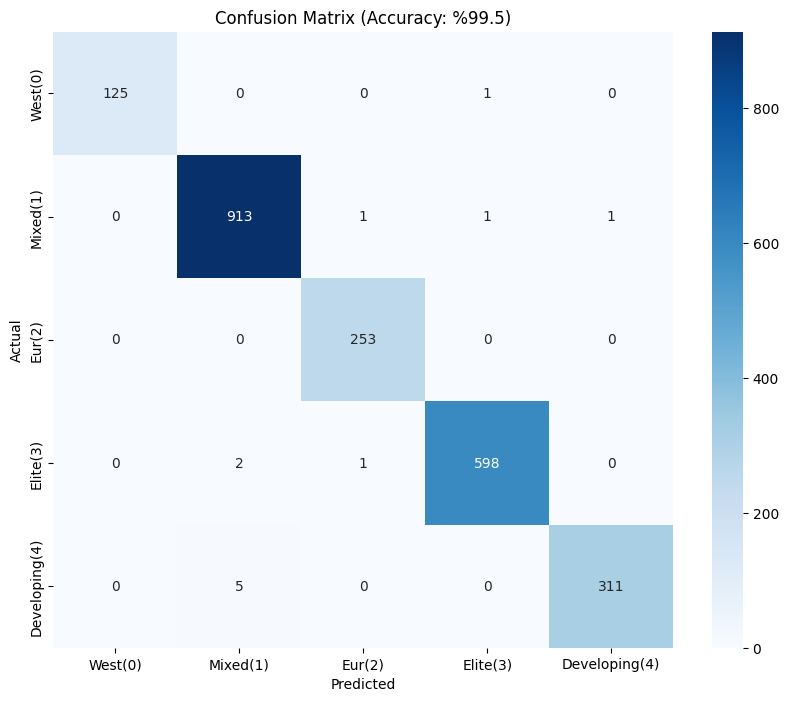

In [11]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True,fmt='d',cmap='Blues',
    xticklabels=["West(0)", "Mixed(1)", "Eur(2)", "Elite(3)", "Developing(4)"],
    yticklabels=["West(0)", "Mixed(1)", "Eur(2)", "Elite(3)", "Developing(4)"])

plt.title(f'Confusion Matrix (Accuracy: %{final_acc*100:.1f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 7) Visualization: Feature Importance

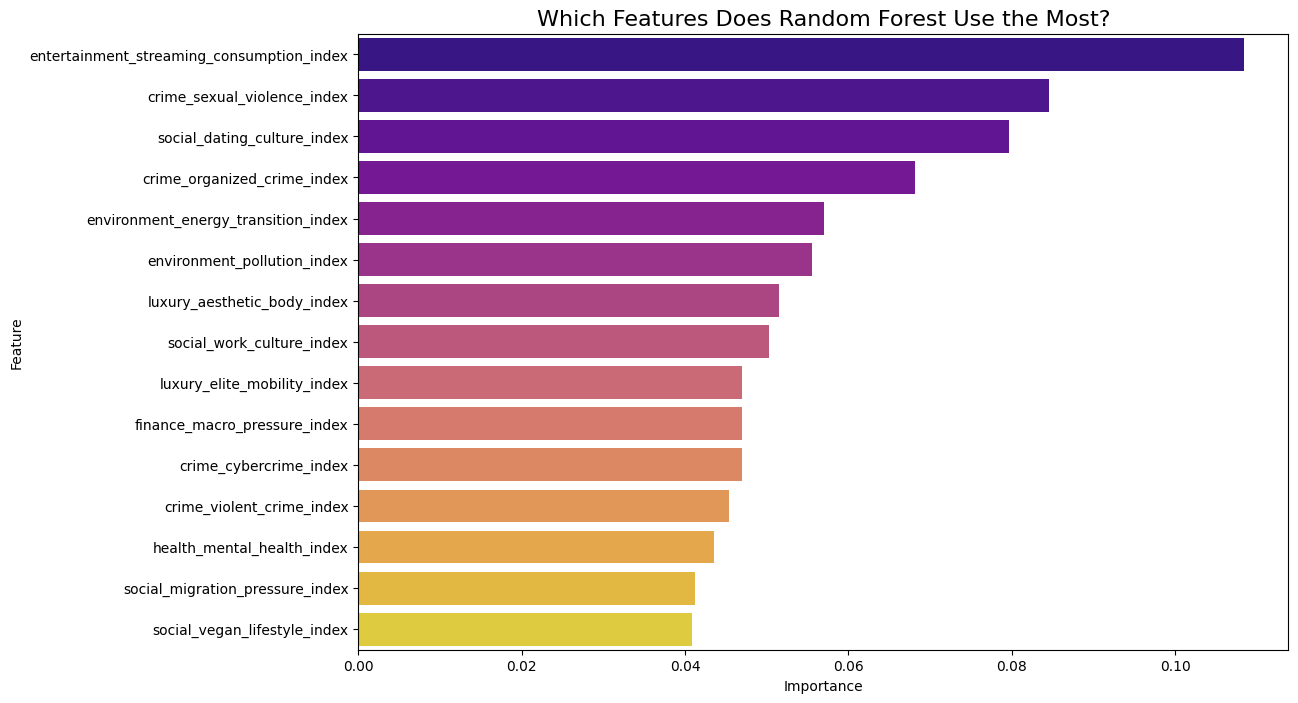

In [12]:
#  Feature Importance
importances = final_model.feature_importances_
feature_names = X.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))

sns.barplot( x='Importance',  y='Feature', data=feature_imp_df.head(15),hue='Feature', palette='plasma',legend=False)

plt.title('Which Features Does Random Forest Use the Most?', fontsize=16)
plt.show()